# Методы понижения размерности

## Уменьшение признакового пространства

Возможны два подхода:
* отбор признаков - в этом мы уже специалисты
* преобразование признаков - а вот этим будем заниматься сегодня

Метод главных компонент - метод поиска приближённого признакового пространства меньшей размерности, в котором новые признаки являются линейными комбинациями старых

Стараемся сохранить как можно больше информации об исходном пространстве

## PCA

Исходная постановка задачи:

* Есть $m$ $d$-мерных векторов: $x_1, \ldots, x_m$, $x_i \in \mathbb{R}^d$
* Хотим перейти из $d$-мерного пространства в $n$-мерное ($n << d$)
* Хотим потерять как можно меньше информации (возможно, иметь возможность потом восстановиться)
$$
		\arg\min\limits_{W\in \mathbb{R}^{n\times d}, U\in \mathbb{R}^{d\times n}} \sum\limits_{i=1}^m ||x_i - UWx_i||^2_2
$$
* Решение этой задачи и называется методом главных компонент

Теорема о виде решения:

Пусть $x_1, \ldots, x_m$ - векторы из $\mathbb{R}^d$, $A=\sum\limits_{i=1}^mx_ix_i^T$. Пусть $u_1, \ldots, u_n$ - собственные векторы, соответствующие $n$ наибольшим собственным значениям матрицы $A$. Тогда решение задачи PCA - взять матрицу $U$, колонки которой - векторы $u_1,\ldots, u_n$

Не вдаваясь в математические подробности, разберёмся, как это выглядит на практике!

In [147]:
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

matplotlib.rc('font', size= 22)


sns.set_style("dark")

np.random.seed(0)
data = np.random.multivariate_normal(mean=[3, 4], cov=[[2, -1.9], [-1.9, 3]], size=30)

In [148]:
def draw_points(ax, points, **kwargs):
    ax.set_xlim([-5, 10])
    ax.set_ylim([-5, 10])
    ax.grid()
    return ax.scatter(x=points[:, 0], y=points[:, 1], s=120, **kwargs)
    
def draw_component(ax, i, pca, **kwargs):
    bias = pca.mean_
    kwargs.setdefault('width', 0.1)
    return ax.arrow(*bias, *(pca.components_[i] * pca.explained_variance_[i]), **kwargs)

Сгенерируем какую-нибудь небольшую обучающую выборку и посмотрим на примере, как работает PCA:

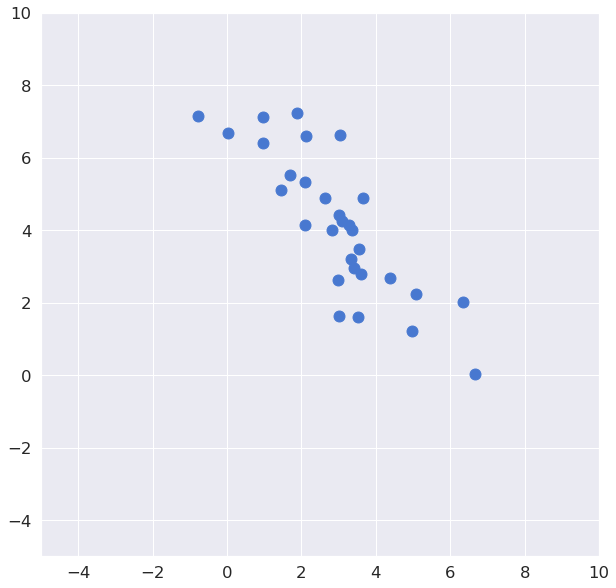

In [149]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
draw_points(ax, data)

In [150]:
pca = PCA(n_components=2).fit(data)

Собственно, главные компоненты:

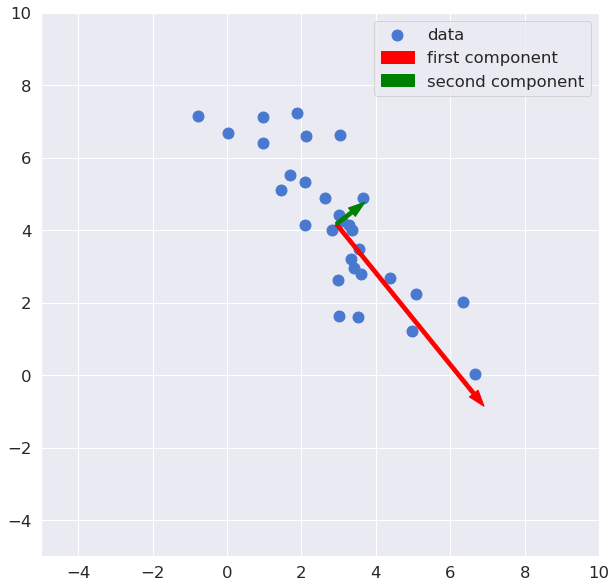

In [151]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.legend([
    draw_points(ax, data),
    draw_component(ax, 0, pca, color='red'),
    draw_component(ax, 1, pca, color='green')
],
[
    'data',
    'first component',
    'second component'
]);

In [152]:
pca = PCA(n_components=1).fit(data)
projected_data = pca.transform(data)

Более наглядная картинка с точки зрения того, что происходит вдоль каждой компоненты:

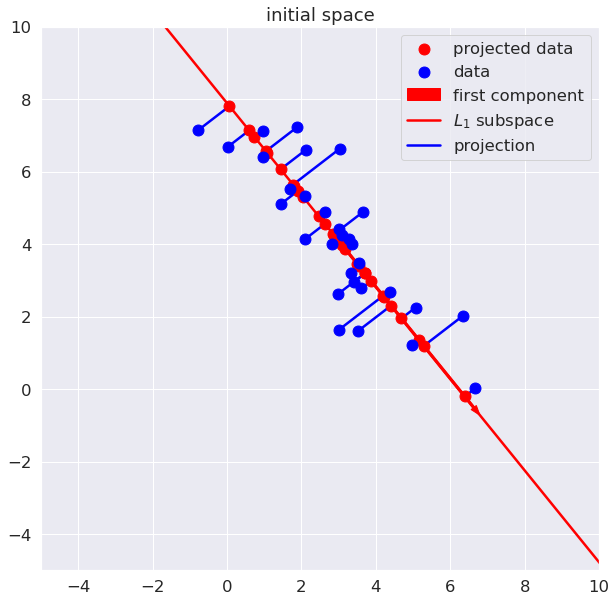

In [153]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

a_0 = pca.mean_
a_1 = pca.components_[0]

# get points on L_1
projected_points = a_0 + a_1 * (data - a_0).dot(a_1)[:, None]

# draw L_1
p = a_0 + np.array([[-10], [20]]) * a_1
ax.plot(p[:, 0],  p[:, 1], color='red')
L_1 = Line2D([0], [0], color='red')

# draw first principal component
component = draw_component(ax, 0, pca, color='red', width=0.06),
proj = Line2D([0], [0], color='blue')

# draw direction of projection
for pp, p in zip(projected_points, data):
    ax.plot([p[0], pp[0]], [p[1], pp[1]], color='blue')


ax.legend([
    draw_points(ax, projected_points, color="red", zorder=11),
    draw_points(ax, data, color='blue', zorder=11),
    component,
    L_1,
    proj
],
[
    'projected data',
    'data',
    'first component',
    '$L_1$ subspace',
    'projection'
]);
ax.grid()
ax.set_title('initial space');

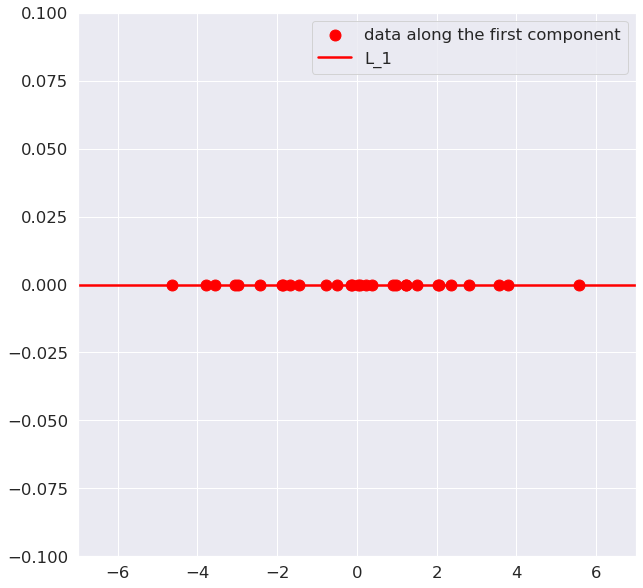

In [154]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot([-7, 7], [0, 0], color='red')
ax.legend([
    draw_points(ax, np.hstack([projected_data, np.zeros_like(projected_data)]), color='red'),
    Line2D([0], [0], color='red')
],
[
    'data along the first component',
    'L_1'
]);
ax.set_xlim([-7, 7])
ax.set_ylim([-0.1, 0.1]);

Но не стоит думать, что всегда всё так хорошо. Надо помнить, что PCA - это линейное преобразование. Поэтому с некоторыми выборками работает плохо:

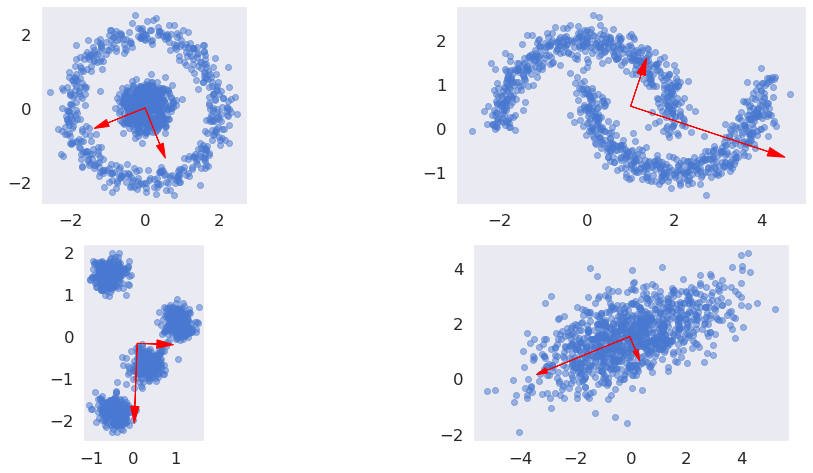

In [155]:
from sklearn.datasets import make_circles, make_moons, make_blobs

def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)
    
    dec = PCA()
    dec.fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.2, head_length=0.4, fc='r', ec='r')
    
    ax.set_aspect('equal', adjustable='box')

np.random.seed(54242)
data_synth_bad = [
    make_circles(n_samples=1000, factor=0.2, noise=0.1)[0]*2,
    make_moons(n_samples=1000, noise=0.1)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    np.random.multivariate_normal(
        mean=[0, 1.5], 
        cov=[[3, 1], 
             [1, 1]],
        size=1000),
]


plt.figure(figsize=(16,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

Но нам не привыкать, что там где не справляются линейные методы, справится введение ядер!

Вспоминаем: речь идёт о матрице ковариации признаков $X^TX$, то есть вычисляются скалярные произведения. А там, где есть скалярные произведения, можно попробовать их заменить на ядра:

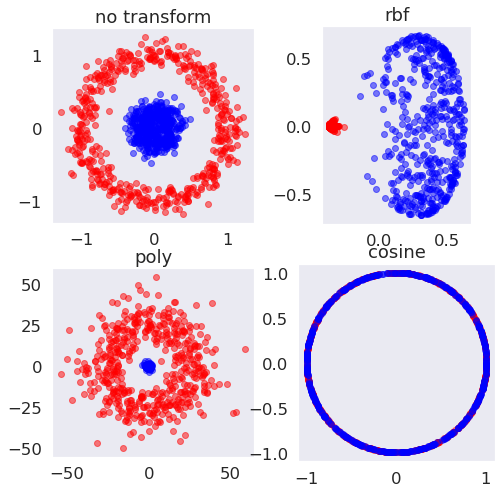

In [156]:
from sklearn.decomposition import KernelPCA


def KPCA_show(X, y):
    reds = y == 0
    blues = y == 1
    
    plt.figure(figsize=(8, 8))
    rows, cols = 2, 2
    plt.subplot(rows, cols, 1)
    plt.scatter(X[reds, 0], X[reds, 1], alpha=0.5, c='r')
    plt.scatter(X[blues, 0], X[blues, 1], alpha=0.5, c='b')
    plt.title('no transform')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    
    kernels_params = [
        dict(kernel='rbf', gamma=10),
        dict(kernel='poly', gamma=10),
        dict(kernel='cosine', gamma=10),
    ]
    
    for i, p in enumerate(kernels_params):
        dec = KernelPCA(**p)
        X_transformed = dec.fit_transform(X)
        
        plt.subplot(rows, cols, i + 2)
        plt.scatter(X_transformed[reds, 0], X_transformed[reds, 1], alpha=0.5, c='r')
        plt.scatter(X_transformed[blues, 0], X_transformed[blues, 1], alpha=0.5, c='b')
        plt.title(p['kernel'])
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        
np.random.seed(54242)
KPCA_show(*make_circles(n_samples=1000, factor=0.2, noise=0.1))

### Лица людей

Ниже представлены элементы датасета с лицами людей. Последнее - ''среднее'' лицо:

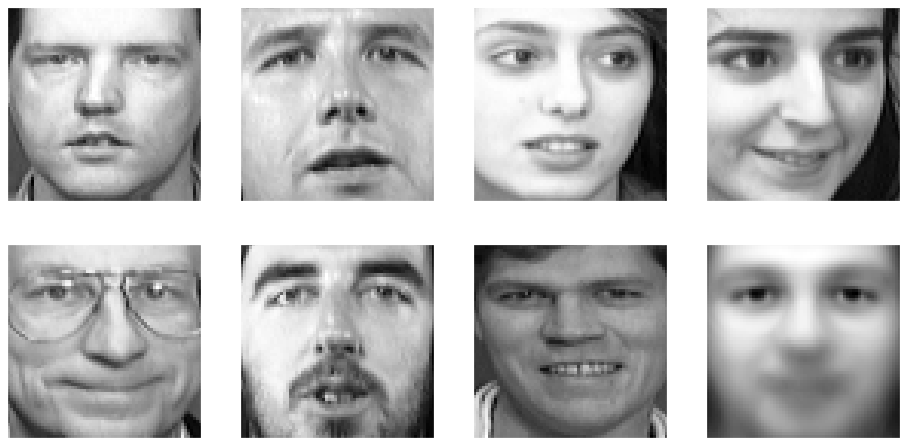

In [157]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True, random_state=432542)
faces_images = faces.data
faces_ids = faces.target
image_shape = (64, 64)
    
mean_face = faces_images.mean(axis=0)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(faces_images[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
plt.subplot(rows, cols, n_samples)
plt.imshow(mean_face.reshape(image_shape), interpolation='none',
           cmap='gray')
plt.xticks(())
_ = plt.yticks(())

Давайте визуализируем те самые главные компоненты!

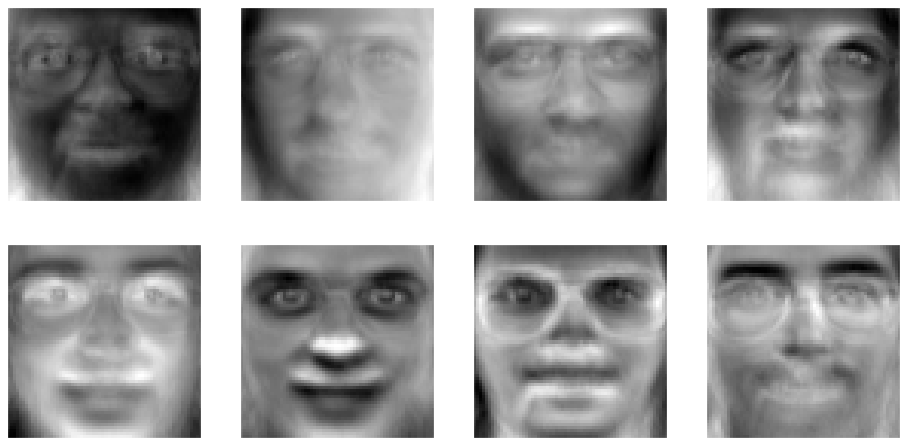

In [158]:
red = PCA()
faces_images -= mean_face
red.fit(faces_images)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(red.components_[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())

Выглядит, конечно, прикольно, но может быть ещё на что-нибудь сгодится?

**Более лучшие признаки**

Да, я знаю, что так говорить неграмотно. Да, если перебирать по бОльшей сетке, то результат будет ещё лучше:

In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gscv_rf = GridSearchCV(RandomForestClassifier(),
                       {'n_estimators': [100], 'max_depth': [2]},
                       cv=5)

In [160]:
gscv_rf.fit(faces_images, faces_ids)
print(gscv_rf.best_score_)

0.505


In [161]:
gscv_rf.fit(red.transform(faces_images)[:,:100], faces_ids)
print(gscv_rf.best_score_)

0.7050000000000001


**Сжатие данных**

Если есть главные компоненты, то есть и неглавные. И если их выбросить, то для картинки измениться ничего особо не должно:

In [162]:
base_size = image_shape[0] * image_shape[1]

def compress_and_show(compress_ratio):
    red = PCA(n_components=int(base_size * compress_ratio))
    red.fit(faces_images)

    faces_compressed = red.transform(faces_images)
    faces_restored = red.inverse_transform(faces_compressed) + mean_face

    plt.figure(figsize=(16, 8))
    rows, cols = 2, 4
    n_samples = rows * cols
    for i in range(n_samples):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(faces_restored[i, :].reshape(image_shape), interpolation='none',
                   cmap='gray')
        plt.xticks(())
        plt.yticks(())

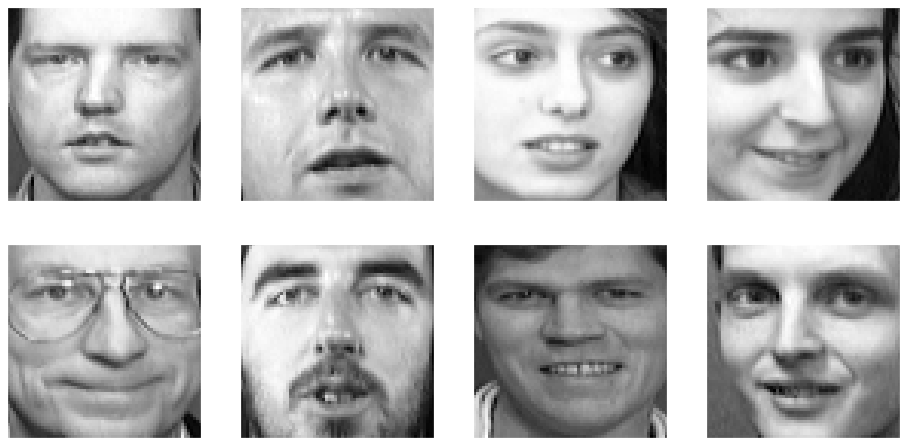

In [163]:
compress_and_show(0.09)

**Задание 1. (1 балл)**. Так уж выходит, что люди часто любят преобразовывать длинные векторы (в том числе и картинки) в латентные пространства более низкой размерности. Обычно получается, что эти латентные пространства обладают всякими интересными свойствами. Например, в них можно брать линейные комбинации векторов, соответствующих объектам, декодировать и получать объекты похожего толка. Это вам и предлагается сделать!

А именно, напишите функцию, которая будет работать с выборкой лиц. Пускай она принимает на вход два индекса - индексы изображений-лиц из выборки. А на выходе визуализирует ''путешествие'' между этими лицами в латентном пространстве.

Более формально, если у вас есть два изображения $I_1$ и $I_2$, а также методы кодирования $Encode(I)$ и декодирования $Decode(I)$ этих изображений в вектор небольшой размерности (здесь это PCA), можно получить последовательность изображений:
$$
I_j = Decode(\alpha_j Encode(I_1) + (1 -\alpha_j) Encode(I_2)),\ \alpha_j = \frac{j}{k}, j=0,\ldots,k
$$

<AxesSubplot:>

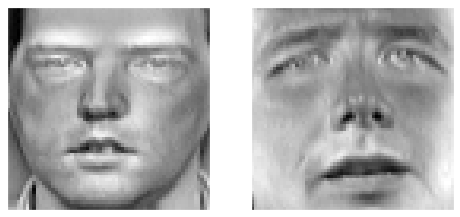

In [164]:
faces_images = faces.data
faces_ids = faces.target
image_shape = (64, 64)

plt.figure(figsize=(8, 4))
rows, cols = 1, 2
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(faces_images[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
plt.subplot(rows, cols, n_samples)

In [165]:
two_img = np.array([faces.data[0, :], faces.data[1, :]])
# faces_ids = np.array([faces.target[0, :], faces.target[1, :]]
image_shape = (64, 64)
    
mean_two = two_img.mean(axis=0)

base_size = image_shape[0] * image_shape[1]

def two_image_travel(k, kernel):
    red = KernelPCA(n_components=int(base_size * 0.09), kernel=kernel, gamma=10, fit_inverse_transform = True)
    red.fit(faces_images)
    
    faces_compressed = red.transform(two_img)
    faces_restored = red.inverse_transform(faces_compressed)

    plt.figure(figsize=(16, 8))
    rows, cols = 1, k + 2    
    for i in range(k + 1):
        plt.subplot(rows, cols, i + 1)
        plt.imshow((red.inverse_transform((i * 1.0 / k) * faces_compressed[0, :].reshape(1, -1) + 
                   (1 - i * 1.0 / k) * faces_compressed[1, :].reshape(1, -1))).reshape(image_shape), interpolation='none',
                   cmap='gray')
        plt.xticks(())
        plt.yticks(())

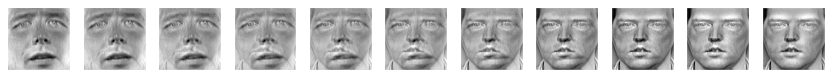

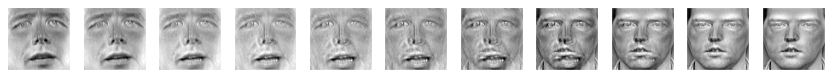

In [166]:
two_image_travel(10, 'linear')
two_image_travel(10, 'poly')

### Финальная ремарка про геометрическую интерпретацию

![](https://i.ibb.co/ZdYXLBf/Screenshot-from-2020-03-30-09-01-46.png)

По теореме Пифагора, суммарное расстояние от точек выборки до центра равно суммарной ошибке проекции плюс дисперсии. И эта величина константна. Значит чем больше дисперсия - тем меньше ошибка проекции.

### Гифка для привлечения внимания к теме

![ChessUrl](https://i.stack.imgur.com/Q7HIP.gif)

### Полезные ссылки

* https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca - про PCA и его отношение с SVD
* https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579 - прекрасный комментарий-история про PCA (начинается со слов "Imagine a big family dinner, where everybody starts asking you about PCA"), гифка оттуда

## t-SNE

В отличии от PCA, задача t-SNE - это сохранить пространственную структуру данных. Например, это может быть полезно для визуализации.

Идея метода заключается в следующем:

* превратим расстояния между объектами в исходном пространстве в вероятности: 

$$p_{j|i} = \frac{\exp{(-d(\boldsymbol{x}_i, \boldsymbol{x}_j) / (2 \sigma_i^2)})}{\sum_{i \neq k} \exp{(-d(\boldsymbol{x}_i, \boldsymbol{x}_k) / (2 \sigma_i^2)})}, \quad p_{i|i} = 0,$$

* посчитаем некоторую новую метрику

$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}.$$

* здесь $\sigma_i$ определяются автоматически для каждого из объектов так, чтобы в областях с высокой плотностью была дисперсия меньше



* теперь определим вероятностное расстояние между точками в новом пространстве:

$$q_{ij} = \frac{(1 + ||\boldsymbol{y}_i - \boldsymbol{y}_j)||^2)^{-1}}{\sum_{k \neq l} (1 + ||\boldsymbol{y}_k - \boldsymbol{y}_l)||^2)^{-1}},$$

* и будем минимизировать разницу между матрицей расстояний в исходном пространстве и в новом:

$$KL(P||Q) = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$$

* делать это будем с помощью градиентного спуска

* за подробностями - в оригинальную статью

### Гифка для привлечения внимания к теме

![ChessUrl](https://d3ansictanv2wj.cloudfront.net/images/animation-94a2c1ff.gif)

**Задание 2 (1 балл)**. А давайте мы сами тоже получим такую красивую картинку :)
* загрузите датасет с цифрами из sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)
* используйте t-SNE (https://scikit-learn.org/0.20/modules/generated/sklearn.manifold.TSNE.html) на 64-мерных векторах фичей, чтобы сжать их до размерности 2
* визуализируйте новые объекты на плоскости, причём разные классы отобразите разными цветами

In [167]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
X_digits, y_digits = load_digits(return_X_y=True)

In [168]:
print(X_digits.data.shape)
print(y_digits.data.shape)
X_embedded = TSNE(n_components=2).fit_transform(X_digits.data)
print(X_embedded.shape)

(1797, 64)
(1797,)
(1797, 2)


In [188]:
# That's an impressive list of imports.
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

import sklearn
# We import sklearn.
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold._t_sne import (_joint_probabilities, _kl_divergence)
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [189]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [190]:
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

In [172]:
digits_proj = TSNE(random_state=RS).fit_transform(X)

In [173]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(1.45659515e-05, -4.2566495e-05, '0'),
  Text(5.771071e-06, 1.348066e-05, '1'),
  Text(-2.0858552e-05, 3.415282e-05, '2'),
  Text(2.946901e-06, 2.5250089e-05, '3'),
  Text(2.5323638e-05, -3.3991826e-05, '4'),
  Text(-1.4681154e-06, 4.9049086e-05, '5'),
  Text(4.491093e-05, 7.500785e-08, '6'),
  Text(-6.5019685e-06, -1.575984e-05, '7'),
  Text(-1.04766605e-05, 1.7569891e-05, '8'),
  Text(-5.0854223e-06, -2.6697326e-05, '9')])

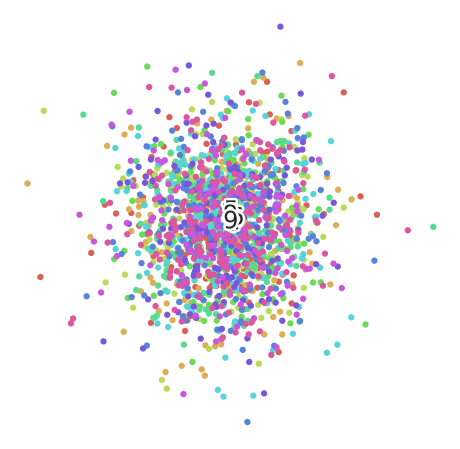

In [174]:
scatter(digits_proj, y)

Text(0.5, 1.0, '$p_{j|i}$ (variable $\\sigma$)')

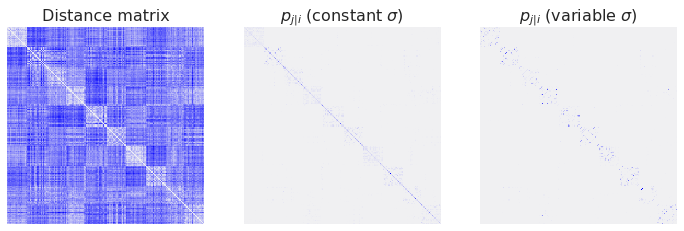

In [175]:
def _joint_probabilities_constant_sigma(D, sigma):
    P = np.exp(-D**2/2 * sigma**2)
    P /= np.sum(P, axis=1)
    return P


# Pairwise distances between all data points.
D = pairwise_distances(X, squared=True)
# Similarity with constant sigma.
P_constant = _joint_probabilities_constant_sigma(D, .002)
# Similarity with variable sigma.
P_binary = _joint_probabilities(D, 30., False)
# The output of this function needs to be reshaped to a square matrix.
P_binary_s = squareform(P_binary)

plt.figure(figsize=(12, 4))
pal = sns.light_palette("blue", as_cmap=True)

plt.subplot(131)
plt.imshow(D[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("Distance matrix", fontdict={'fontsize': 16})

plt.subplot(132)
plt.imshow(P_constant[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (constant $\sigma$)", fontdict={'fontsize': 16})

plt.subplot(133)
plt.imshow(P_binary_s[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (variable $\sigma$)", fontdict={'fontsize': 16})

In [176]:
# This list will contain the positions of the map points at every iteration.
positions = []
def _gradient_descent(objective, p0, it, n_iter, n_iter_without_progress=30, n_iter_check=1, 
                      momentum=0.5, learning_rate=1000.0, min_gain=0.01,
                      min_grad_norm=1e-7, min_error_diff=1e-7, verbose=0,
                      args=None, kwargs=None):
    # The documentation of this function can be found in scikit-learn's code.
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = 0

    for i in range(it, n_iter):
        # We save the current position.
        positions.append(p.copy())

        new_error, grad = objective(p, *args)
        error_diff = np.abs(new_error - error)
        error = new_error
        grad_norm = linalg.norm(grad)

        if error < best_error:
            best_error = error
            best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        if min_grad_norm >= grad_norm:
            break
        if min_error_diff >= error_diff:
            break

        inc = update * grad >= 0.0
        dec = np.invert(inc)
        gains[inc] += 0.05
        gains[dec] *= 0.95
        np.clip(gains, min_gain, np.inf)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

    return p, error, i

In [192]:
sklearn.manifold._t_sne._gradient_descent = _gradient_descent

In [178]:
X_proj = TSNE(random_state=RS).fit_transform(X)

In [179]:
print(positions)

[array([ 2.2526995e-04, -4.1792318e-06,  2.7974791e-06, ...,
        4.8178445e-05, -1.7938757e-04,  1.7921962e-05], dtype=float32), array([-1.2426573e-03,  2.3658991e-04, -5.3589822e-05, ...,
       -3.0551315e-04,  5.3278124e-04,  1.7330723e-05], dtype=float32), array([-1.2426573e-03,  2.3658991e-04, -5.3589822e-05, ...,
       -3.0551315e-04,  5.3278124e-04,  1.7330723e-05], dtype=float32), array([-1.0219881e-03,  1.4422619e-04, -2.2224303e-05, ...,
       -2.0993676e-04,  5.4321944e-04, -2.8730756e-07], dtype=float32)]


In [180]:
X_iter = np.dstack(position.reshape(-1, 2) for position in positions)

t:   0%|          | 0/2 [00:00<?, ?it/s, now=None]

MoviePy - Building file tsme.gif with imageio.


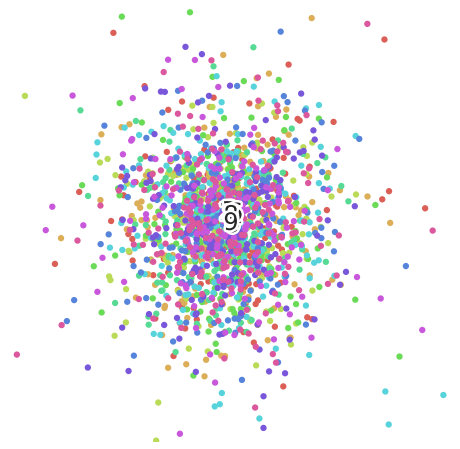

In [181]:
f, ax, sc, txts = scatter(X_iter[..., -1], y)

def make_frame_mpl(t):
    i = int(t*40)
    x = X_iter[..., i]
    sc.set_offsets(x)
    for j, txt in zip(range(10), txts):
        xtext, ytext = np.median(x[y == j, :], axis=0)
        txt.set_x(xtext)
        txt.set_y(ytext)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
animation.write_gif("tsne.gif", fps=20)

### Полезные ссылки

* http://jmlr.csail.mit.edu/papers/volume9/vandermaaten08a/vandermaaten08a.pdf - оригинальная статья про t-SNE
* https://lvdmaaten.github.io/tsne/ - гитхаб автора с примерами применения t-SNE для разных данных (и не только)
* https://distill.pub/2016/misread-tsne/ - очень красивая визуализация на тему t-SNE и подбора параметров
* https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm?imm_mid=0d3385&cmp=em-data-na-na-newsltr_20150610 - объяснение t-SNE с картинками (гифка оттуда)

## Другие алгоритмы понижения размерности

### Truncated SVD

* для того, чтобы вся теория в PCA сходилась и можно было применять метод, данные должны быть нормированы, т.е. иметь нулевое среднее (а лучше и единичную дисперсию)
* нормировать, например, разреженные матрицы очень неудобно: они перестают быть разреженными
* Truncated SVD позволяет добиваться того же самого, но без нормировки

### IncrementalPCA

* когда речь заходит об огромном количестве данных, как-то пользоваться алгоритмами примерно кубической сложности (каким является PCA) не очень удобно
* но существуют методы, которые умеют принимать выборку небольшими кусочками и их сложность зависит не от объёма всей выборки, а от объёма кусочка
* таким алгоритмом, например, является IncrementalIPCA

https://www.kaggle.com/shivamb/dataset-decomposition-techniques - про разные схемы понижения размерности на примере одного kaggle-соревнования

# Многоклассовая классификация

Иногда в жизни нужно решать задачу многоклассовой классификации:
* классификация цифр
* классификация лиц
* ирисы

Но есть и **мульти**классовая классификация:
* многоклассовая - это предсказать одну метку для каждого объекта, но всего вариантов тьма
* мультиклассовая - это предсказать много меток для каждого объекта, а вариантов всё равно тьма

Значит придётся и нам учиться!

Как правило, есть 3 варианта:
* взять бинарный классификатор и сделать One vs. One
* взять бинарный классификатор и сделать One vs. Rest
* обобщить методы бинарной классификации на бОльшие размерности

Разберёмся с последним:
* kNN плевать на то, сколько классов
* решающим деревьям тоже
* а вот с линейными методами чуть сложнее...

Двухклассовая классификация:
* $$
			a(x) = sign\langle w, x\rangle
$$
* $$
			a(x) = sign(\langle w, x\rangle - \langle -w, x\rangle)
$$
* $$
			a(x) = \arg\max\limits_{k\in \{-1, +1\}} \langle w_k, x\rangle 
$$
* $$
			w_{+1} = w,\ w_{-1} = -w
$$

Многоклассовая классификация:\pause
* $$
			a(x) =  \arg\max\limits_{k\in \{1, \ldots, K\}} \langle w_k, x\rangle 
$$

## One vs. One

![](https://i.imgur.com/NreKSdj.png)

## One vs. Rest

![](https://i.imgur.com/zZ8Ey32.png)

## А теперь на практике!

Сгенерируем небольшую выборку данных для трёхклассовой классификации:

In [200]:
from sklearn.datasets import make_classification

In [201]:
X, y = make_classification(n_features=2, n_classes=3, n_informative=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1)

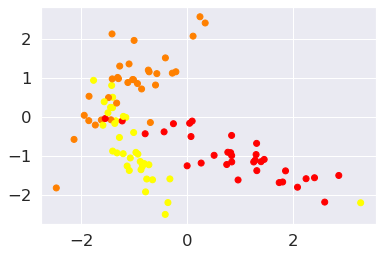

In [202]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

**Задание 3 (1 балл).** Давайте сравним методы (One vs. One) vs. (One vs. Rest). Используя логистическую регрессию и соответствующие методы из sklearn (https://scikit-learn.org/0.20/modules/generated/sklearn.multiclass.OneVsOneClassifier.html#sklearn.multiclass.OneVsOneClassifier и https://scikit-learn.org/0.20/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier), численно, нарисовав confusion matrix (https://scikit-learn.org/0.20/modules/generated/sklearn.metrics.confusion_matrix.html) для того, чтобы определить, какие классы чаще всего смешиваются в каждом из методов.

In [203]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

model = LogisticRegression()

ovr = OneVsRestClassifier(model)
ovr.fit(X, y)

y_ovr = ovr.predict(X)

ovo = OneVsOneClassifier(model)
ovo.fit(X, y)

y_ovo = ovo.predict(X)

In [204]:
confusion_matrix(y, y_ovo)

array([[29,  0,  4],
       [ 0, 26,  7],
       [ 1,  7, 26]])

In [205]:
confusion_matrix(y, y_ovr)

array([[29,  0,  4],
       [ 0, 25,  8],
       [ 1,  8, 25]])

Видно, что в One vs One смешиваний меньше, чем в One vs Rest. По сути при увеличенний кол-ва классов и данных OvO становился бы только лучше по сравнению с OvR, т.к. считает гораздо больше всего и легко разделяем, а OvR просто быстрый, но не такой точный.